# Extract Claims Using the Script

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
def get_patent_page(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.text

def parse_claims(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    claims_section = soup.find('section', {'itemprop': 'claims'})
    claims = []

    if claims_section:
        claims_list = claims_section.find_all('div', {'class': 'claim-text'})
        for claim in claims_list:
            claims.append(claim.get_text(strip=True))
    else:
        print("Claims section not found.")
    
    return claims

def extract_claims(url):
    page_content = get_patent_page(url)
    return parse_claims(page_content)

# URLs of the patents to extract claims from
urls = [
    "https://patents.google.com/patent/GB2478972A/en?q=(phone)&oq=phone",
    "https://patents.google.com/patent/US9634864B2/en?oq=US9634864B2",
    "https://patents.google.com/patent/US9980046B2/en?oq=US9980046B2"
]

# Extract claims from each URL
all_claims = []
for url in urls:
    claims = extract_claims(url)
    all_claims.extend(claims)

# Group Claims

## K-Means Clustering

In [3]:
# please choose the number of groups you want for this task
k = 4

In [4]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Convert claims to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(all_claims)

In [7]:
# Apply K-Means clustering
num_clusters = k  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=4, random_state=42)

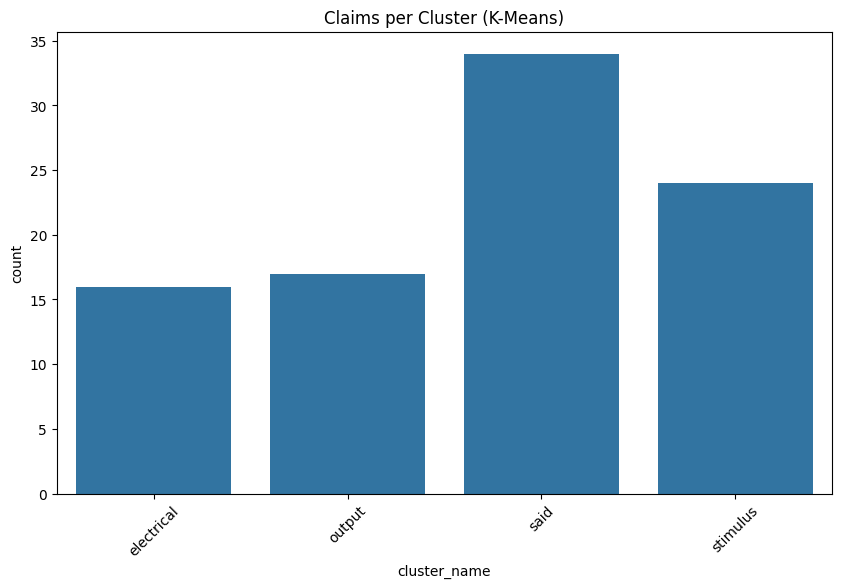

In [8]:
# Assign clusters to claims
claims_df = pd.DataFrame({'claim': all_claims, 'cluster': kmeans.labels_})

# Function to get top term for each cluster
def get_top_term_per_cluster(tfidf_matrix, labels, vectorizer):
    df = pd.DataFrame(tfidf_matrix.todense()).groupby(labels).mean()
    terms = vectorizer.get_feature_names_out()
    top_terms = {}

    for i, row in df.iterrows():
        top_terms[i] = terms[row.argmax()]
    
    return top_terms

# Get top term for each cluster
top_terms = get_top_term_per_cluster(X, kmeans.labels_, vectorizer)

# Create cluster names based on top terms
cluster_names = {i: term for i, term in top_terms.items()}

# Add cluster names to dataframe
claims_df['cluster_name'] = claims_df['cluster'].map(cluster_names)

# Visualize the clustering results with descriptive names
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_name', data=claims_df, order=sorted(cluster_names.values()))
plt.title('Claims per Cluster (K-Means)')
plt.xticks(rotation=45)
plt.show()

# Print each cluster's title and the associated claims
# for cluster, name in cluster_names.items():
#     print(f"Cluster {cluster} - Topic: {name}")
#     cluster_claims = claims_df[claims_df['cluster'] == cluster]['claim'].tolist()
#     for claim in cluster_claims:
#         print(f"  - {claim}")
#     print("\n")

## Latent Dirichlet Allocation (LDA)

In [9]:
# please choose the number of groups you want for this task
k = 3

In [10]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
def group_claims_by_lda(all_claims, num_topics=3, no_top_words=1):

    # Convert claims to TF-IDF features
    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(all_claims)

    # Apply LDA
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Get the top words for each topic
    tf_feature_names = vectorizer.get_feature_names_out()
    topic_words = display_topics(lda, tf_feature_names, no_top_words)

    # Group claims by topics
    topics = lda.transform(X)
    grouped_claims = [[] for _ in range(num_topics)]
    topic_labels = []
    for i, topic_prob in enumerate(topics):
        topic = topic_prob.argmax()
        grouped_claims[topic].append(all_claims[i])
        topic_labels.append(topic)

    return grouped_claims, topic_words, topic_labels


def display_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [
            feature_names[i] for i in topic.argsort()[: -no_top_words - 1 : -1]
        ]
        topic_words.append(" ".join(top_words))
    return topic_words

In [15]:
#grouped_claims, topic_words = group_claims_by_lda(all_claims, k)

# Group claims by LDA
grouped_claims, topic_words, topic_labels = group_claims_by_lda(all_claims, k)

# Create a DataFrame with claims and their assigned topics
claims_df_lda = pd.DataFrame({'claim': all_claims, 'topic': topic_labels})

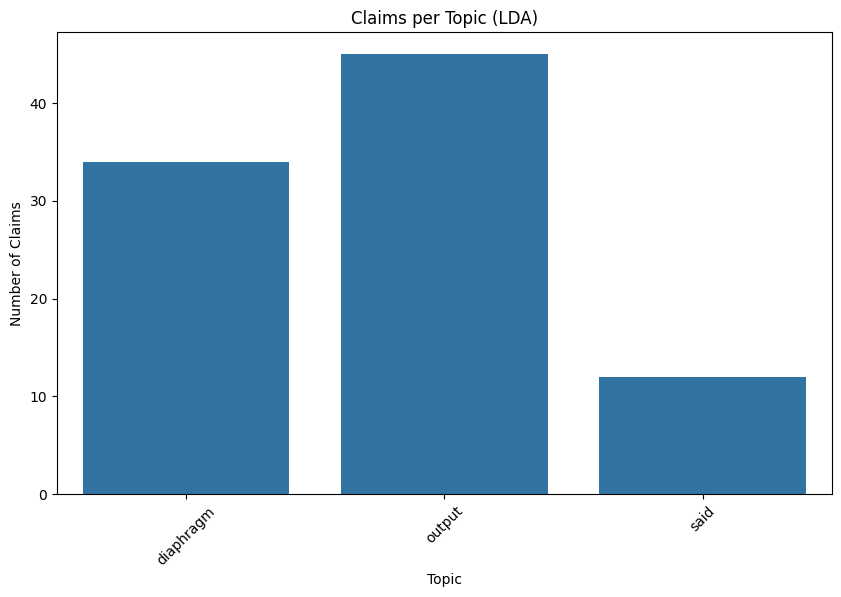

In [17]:


# Create a visualization for the number of claims per topic
plt.figure(figsize=(10, 6))
sns.countplot(x='topic', data=claims_df_lda, order=range(k))
plt.title('Claims per Topic (LDA)')
plt.xlabel('Topic')
plt.ylabel('Number of Claims')
plt.xticks(range(k), topic_words, rotation=45)
plt.show()

In [18]:
response = {"groups": []}
for i, (group, topic) in enumerate(zip(grouped_claims, topic_words)):
    response["groups"].append({"title": topic, "number_of_claims": len(group)})
print(response)


{'groups': [{'title': 'diaphragm', 'number_of_claims': 34}, {'title': 'output', 'number_of_claims': 45}, {'title': 'said', 'number_of_claims': 12}]}


## Hierarchical Clustering

In [19]:
# please choose the number of groups you want for this task
k = 2

In [20]:
from sklearn.cluster import KMeans, AgglomerativeClustering

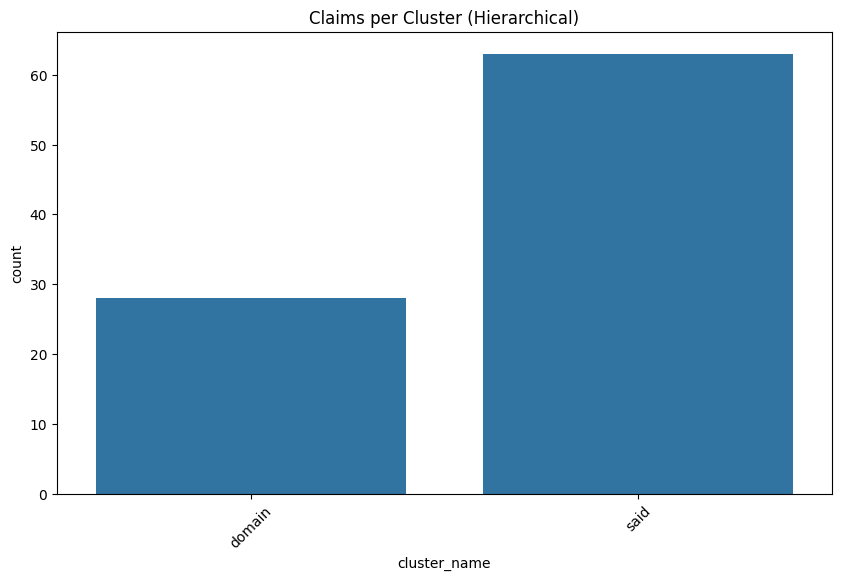

{'groups': [{'title': 'said', 'number_of_claims': 63}, {'title': 'domain', 'number_of_claims': 28}]}


In [21]:
# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=k)
hierarchical_labels = hierarchical.fit_predict(X.toarray())
claims_df_hierarchical = pd.DataFrame({'claim': all_claims, 'cluster': hierarchical_labels})

# Get top term for each cluster in hierarchical clustering
top_terms_hierarchical = get_top_term_per_cluster(X, hierarchical_labels, vectorizer)
cluster_names_hierarchical = {i: term for i, term in top_terms_hierarchical.items()}
claims_df_hierarchical['cluster_name'] = claims_df_hierarchical['cluster'].map(cluster_names_hierarchical)

# Visualize hierarchical clustering results
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_name', data=claims_df_hierarchical, order=sorted(cluster_names_hierarchical.values()))
plt.title('Claims per Cluster (Hierarchical)')
plt.xticks(rotation=45)
plt.show()

# Print each cluster's title and the associated claims for hierarchical clustering
response_hierarchical = {"groups": []}
for i, (group, topic) in enumerate(zip(top_terms_hierarchical.keys(), top_terms_hierarchical.values())):
    response_hierarchical["groups"].append({"title": topic, "number_of_claims": len(claims_df_hierarchical[claims_df_hierarchical['cluster'] == i])})

print(response_hierarchical)